In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/the-depression-dataset/data/scores.csv
../input/the-depression-dataset/data/condition/condition_20.csv
../input/the-depression-dataset/data/condition/condition_2.csv
../input/the-depression-dataset/data/condition/condition_16.csv
../input/the-depression-dataset/data/condition/condition_23.csv
../input/the-depression-dataset/data/condition/condition_18.csv
../input/the-depression-dataset/data/condition/condition_8.csv
../input/the-depression-dataset/data/condition/condition_1.csv
../input/the-depression-dataset/data/condition/condition_22.csv
../input/the-depression-dataset/data/condition/condition_5.csv
../input/the-depression-dataset/data/condition/condition_19.csv
../input/the-depression-dataset/data/condition/condition_13.csv
../input/the-depression-dataset/data/condition/condition_15.csv
../input/the-depression-dataset/data/condition/condition_21.csv
../input/the-depression-dataset/data/condition/condition_17.csv
../input/the-depression-dataset/data/condition/condition_11.

In [23]:
#load in MADRS1 and MADRS2 scores
scores =  pd.read_csv("../input/the-depression-dataset/data/scores.csv")
MADRS1 = np.array(scores["madrs1"])
MADRS2 = np.array(scores["madrs2"])
MADRS = np.vstack((MADRS1,MADRS2))
#print(MADRS1)
#print(MADRS2)
#print(MADRS)

# discard Nan (healthy subjects),keep the average of only condition subjects for convenience
import math
nanvals = np.where(np.isnan(MADRS))
MADRScondition = np.delete(MADRS, nanvals[1], 1)
MADRScondition = np.mean(MADRScondition, axis = 0)
MADRScontrol = (np.ones(32))*(-1)
print(MADRScondition)
print(MADRScontrol)
print(MADRScondition.shape)
print(MADRScontrol.shape)
#MADRS =np.nan_to_num(MADRS, nan=-1)
#print(MADRS.shape)

[19.  17.5 24.5 18.  26.  16.5 24.5 18.  26.  24.5 24.  23.  15.5 23.5
 16.  15.  16.  16.5 23.5 26.  23.5 28.5 26. ]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(23,)
(32,)


In [24]:
def convert_timestamps(timestamps): #  panda series ==to==> [Hours][Minutes] (list)
    from datetime import datetime
    HH_MM = [0, 0]*len(timestamps)   
    for i in range(len(timestamps)):
        t = timestamps.iloc[i][0]
        d = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')       
        h,m = d.hour, d.minute
        HH_MM[i] = h,m        
    return HH_MM


def read_subject(cohort,subj): # read subject data from the folder; 
    filename = cohort+"_"+str(subj)+".csv";
    file = pd.read_csv("../input/the-depression-dataset/data/"+cohort+"/"+filename,header=0)
    timestamps = file.iloc[:,[0]]
    dates = file.iloc[:,[1]]
    activity = file.iloc[:,[2]]     
    HH_MM = convert_timestamps(timestamps)
    
    # convert dataframe to array
    activity = np.array(activity)
    activity = activity.reshape(-1)

    return HH_MM, activity

def rearrange_in_days(HH_MM, activity): # stacks days of recorded activity
    midnights = idx(HH_MM,(0,0))    
    for i in range(0,len(midnights)-1):
        day_i = activity[midnights[i]:(midnights[i+1]-1)]
        if i==0: rec = day_i
        elif len(day_i)==minutesinaday: rec = np.vstack((rec,day_i))
    return rec

def gather_data(cohort,subj): # bridge function: use rearrange_in_days and read_subject together
    HH_MM,activity = read_subject(cohort,subj)
    days = rearrange_in_days(HH_MM, activity) 
    return days

def idx(l, target): # returns the pos. of every occurence of 'target'
    output = [];
    for i in range(len(l)):
        if l[i]==target:
            output.append(i)
    return output

def get_subj_index(cohort,subj,I): # helps us finding specific subjects' data in a structured array
    if cohort == "condition":
        subj = subj+32  
    i = np.where(I == subj)
    istart = i[0][0]
    iend = i[0][-1]
    return (istart, iend)

def visualize_data(x,y,style,col = 'black',T ='', l='',xl='', yl='',xlimit=None):
    import matplotlib.pyplot as plt
    if style =='plot':
        plt.plot(x,y,color = col, label = l)
    if style =='scatter':
        plt.scatter(x,y,color = col, label = l)  
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(T)
    if not(xlimit is None):
        plt.xlim((xlimit[0],xlimit[1]))
    return None  
    
def feature_extract(X):
    featurevec = []
    t = np.linspace(0,360-(360/1439),1439)
    for day in X:
        f1 = np.mean(day)
        f2 = np.std(day)
        f3 = np.max(day)
        f,f4,f5,f6= cosinor(t,day)
        f8 = np.sum(day)**2
        featurevec.append([f1,f2,f3,f5,f6])
        
    X_feat = np.array(featurevec)
    return X_feat

In [25]:
Ncontr = 32 # number of control subjects
Ncond  = 23 # number of condition subjects
minutesinaday = 1439 # from 00:00 to 23:59 there are 1439 minutes

counter = 1
for subj in range(1,Ncontr):
    cohort = "control"
    
    days = gather_data(cohort,subj)
    ndays = days.shape[0];
    MADRSzeros = np.zeros(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter=counter+1
    
    if subj == 1: # array init
        Y = MADRScontrol 
        X = days
        ID= subj_id 
        
    else:         # array expansion
        X = np.vstack((X,days))
        Y = np.hstack((Y,MADRScontrol))
        ID= np.hstack((ID,subj_id))

    
for subj in range(1, Ncond):
    cohort = "condition"
    
    days = gather_data(cohort,subj)
    ndays = days.shape[0];
    MADRSone = np.ones(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter=counter+1
    
    X = np.vstack((X,days))
    Y = np.hstack((Y,MADRScondition))
    ID= np.hstack((ID,subj_id))
    
print(X)
print(Y)
print(ID)

[[   0    0    0 ...    0    0    0]
 [  73    0    0 ... 1002   57  111]
 [ 231   15    0 ...    0    0  620]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
[-1.  -1.  -1.  ... 23.5 28.5 26. ]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9

In [26]:
print(X.shape)
print(Y.shape)

(974, 1439)
(1498,)


there are approximately  213  suspiciously low-activity days


Text(0.5, 0.98, 'suspicious recordings')

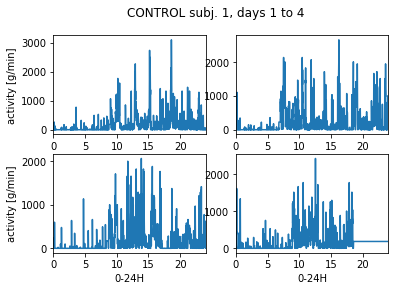

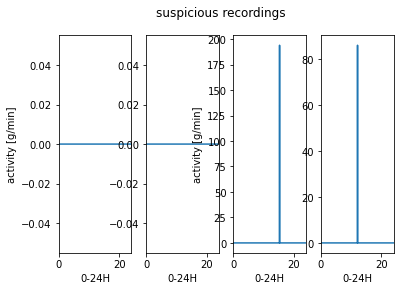

In [27]:
import matplotlib.pyplot as plt  
ax = np.arange(0, 24+0.0167, 0.0167) # X-Axis to plot 0-24H

# HOW DATA LOOKS LIKE? 
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(ax, X[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("CONTROL subj. 1, days 1 to 4")

# ARE THERE ANY INCONSISTENCIES?
threshold = 25 
X_mean = np.mean(X,axis=1)
sus = np.where(X_mean<threshold)
sus = sus[0]
print("there are approximately ",len(sus)," suspiciously low-activity days")
plt.figure()
plt.subplot(1,4,1)
plt.plot(ax,X[sus[0]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,2)
plt.plot(ax,X[sus[1]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,3)
plt.plot(ax,X[sus[2]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,4)
plt.plot(ax,X[sus[3]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("suspicious recordings")

original dataset size:  (974, 1439)
 cleaned dataset size:  (761, 1439)


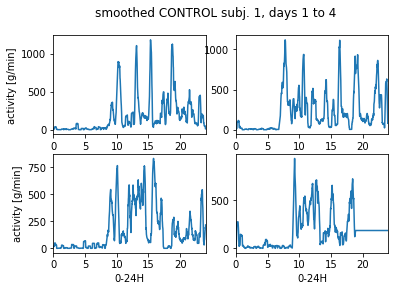

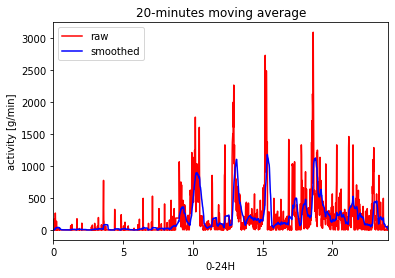

In [28]:
print("original dataset size: ",X.shape)
X = np.delete(X,sus,axis=0)
Y = np.delete(Y,sus,axis=0)
ID= np.delete(ID,sus,axis=0)
print(" cleaned dataset size: ",X.shape)

# input: time series ==> output: smoothed time series
def smooth(day,win):
    from scipy import signal
    import numpy as np
    
    L = win #L-point Moving Average filter
    b = (np.ones(L))/L #numerator co-effs of filter transfer function
    a = np.ones(1)   #denominator co-effs of filter transfer function
    x = day 
    y = signal.lfilter(b,a,x) #filter output using lfilter function
    return y

# 20-Minutes Moving Average Filter
window = 20
for i in range(0,X.shape[0]):
    day = X[i]
    smoothed_day = smooth(day,window)
    
    if i==0: 
        X_smooth = smoothed_day
    else: 
        X_smooth = np.vstack((X_smooth,smoothed_day))

    
plt.figure()
plt.subplot(2,2,1)
plt.plot(ax, X_smooth[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X_smooth[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X_smooth[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X_smooth[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("smoothed CONTROL subj. 1, days 1 to 4")

plt.figure()
plt.title("20-minutes moving average")
plt.plot(ax,X[0],color='r',label="raw"),plt.ylabel("activity [g/min]")
plt.plot(ax,X_smooth[0],color='b',label="smoothed"),plt.xlabel("0-24H"),plt.xlim(0,24)
plt.legend()
plt.show()

In [29]:
#Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
LR = LinearRegression()
LR.fit(x_train, y_train)

y_prediction = LR.predict(x_test)
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print("r2 score is " + str(score))
print("mean_sqrd_error is "+ str(mean_squared_error(y_test,y_prediction)))
print("root_mean_squared error is " + str(np.sqrt(mean_squared_error(y_test,y_prediction))))

ValueError: Found input variables with inconsistent numbers of samples: [761, 1285]

In [ ]:
#XGBoost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

XGB = XGBClassifier()
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
XGB.fit(x_train, y_train)
# make predictions for test data
y_pred = XGB.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#Support Vector Machine (SVM)
from sklearn.svm import SVC
SVM = SVC(kernel='linear')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
SVM.fit(x_train,y_train)
y_pred = SVM.predict(x_test)
print(accuracy_score(y_test,y_pred))

In [ ]:
#Multi-Layer Perceptron (MLP)
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
MLP.fit(x_train,y_train)
y_pred=MLP.predict(x_test)
accuracy_score(y_test,y_pred)